In [1]:
using Revise
using QSimulator
using Plots
using Optim
using LsqFit
using ProgressMeter
pyplot()

Plots.PyPlotBackend()

In [2]:
# Given fmin, fmax, and anharmonicity, find the EC, EJ, and d for the tunable qubit
fmax = 4524.2/1e3
fmin = 3292.3/1e3
αmax = -193.02/1e3
dim = 3

EC, EJ, d = QSimulator.fit_tunable_transmon(fmax,fmin,αmax, TunableDuffingTransmon)

(0.19302, 14.41053033908403, 0.5458999499530235)

In [3]:
# Define the fixed and tunable transmon 
q0 = FixedDuffingTransmon("q0", 5, -0.2, 3);
q1 = TunableDuffingTransmon("q1",  EC, EJ, d, dim);

fix_qubit_freq = hamiltonian(q0)[2,2];
tun_qubit_freq = hamiltonian(q1,0)[2,2]

4.524199999999999

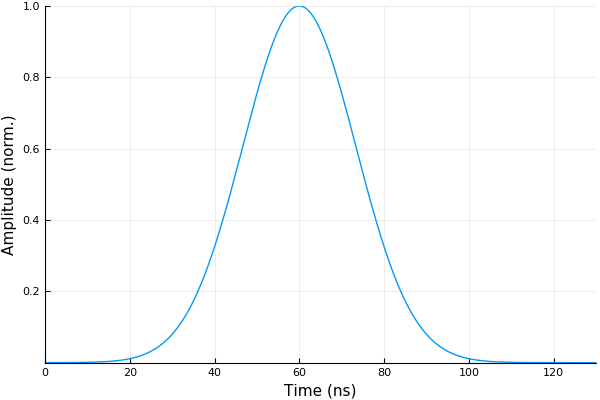

In [4]:
#Define and plot Gaussian pulse of unit amplitude

function gaussian(pulse_length, pulse_freq, t, t0; cutoff=3.0)
    σ = pulse_length/2/cutoff
    pulse = exp(-0.5*((t-pulse_length/2-t0)/σ)^2)
    pulse * cos(2π*pulse_freq * (t-t0))
end

t0 = 20 # initial time delay
pulse_length = 80.0 
times = 0:0.1:(t0+pulse_length+30)

plot(times, gaussian.(pulse_length, 0, times, t0),legend=false, xlabel="Time (ns)", ylabel="Amplitude (norm.)")

In [5]:
# power Rabi measurement using the Gaussian pulse in the rotating frame 

amps = linspace(0,0.05, 201) # amplitude array
pulse_end = times[end]
ψ0 = Complex128[1, 0, 0];

states_gaussian = []
@showprogress 1 "Computing..." for amp = amps    
    cqs = CompositeQSystem([q1]);
    add_hamiltonian!(cqs, hamiltonian(q1,0), q1)    
    add_hamiltonian!(cqs, -tun_qubit_freq*number(q1), q1) # move into the rotating frame
    add_hamiltonian!(cqs, microwave_drive(q1, t -> amp*gaussian(pulse_length, 0, t, t0)), q1);
    ψs = unitary_state(cqs, [pulse_end], ψ0)
    push!(states_gaussian, ψs[end])
end
p0 = [abs2(s[1]) for s in states_gaussian]; # |0⟩ state population
p1 = [abs2(s[2]) for s in states_gaussian]; # |1⟩ state population
p2 = [abs2(s[3]) for s in states_gaussian]; # |2⟩ state population

Computing...  0%|                                       |  ETA: 0:15:31
Computing...100%|███████████████████████████████████████| Time: 0:00:05

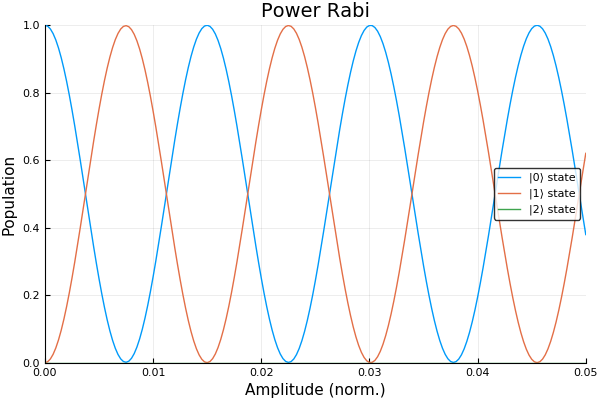

In [6]:
plot(amps, [p0 p1 p2], label=["|0⟩ state" "|1⟩ state" "|2⟩ state"])
plot!( title = "Power Rabi", xlabel = "Amplitude (norm.)", ylabel = "Population")

In [7]:
# Define objective function to optimize π pulse amplitude
function π_pulse_objective(amp)    
    cqs = CompositeQSystem([q1]);
    add_hamiltonian!(cqs, hamiltonian(q1,0), q1)    
    add_hamiltonian!(cqs, -tun_qubit_freq*number(q1), q1) # move into the rotating frame
    add_hamiltonian!(cqs, microwave_drive(q1, t -> amp*gaussian(pulse_length, 0, t, t0)), q1);
    ψs = unitary_state(cqs, [pulse_end], ψ0)    
    return abs2(ψs[end][1]);
end

π_pulse_objective(0.0075)

0.0010790667739082364

In [8]:
# Optimize π pulse amplitude
res = optimize(π_pulse_objective, 0.006, 0.009) # Search in the range of 0.016 to 0.022
π_amp = res.minimizer

0.007479470925149499

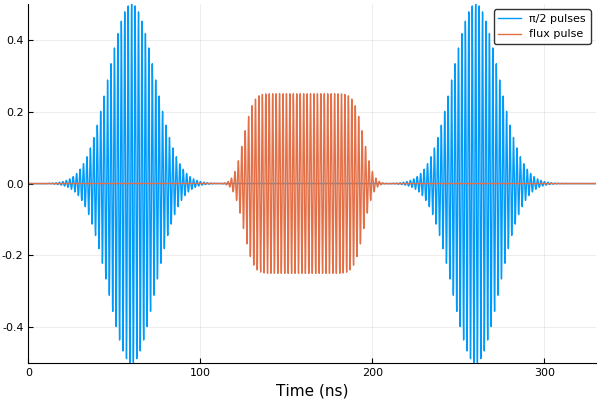

In [9]:
# Define and plot a Ramsey sequence with an ErfSquare pulse inserted during the wait time 
# Ramsey sequence using Gaussian pulses 
function ramsey_gaussian(pulse_length, pulse_freq, t, t0, delay, amp; cutoff=2.5)
    σ = pulse_length/2/cutoff
    pulse = (amp /2.) * gaussian.(pulse_length, pulse_freq, t, pulse_length/2-t0) 
    pulse += (amp /2.) * gaussian.(pulse_length, pulse_freq, t, pulse_length/2-t0+delay)     
end

# Erfsquare pulse 
function erfsquare(t, t0, tmax; risetime=30, pad=10)
    risetime = 30
    fwhm = 0.5 * risetime
    t₁ = fwhm + t0 + pad
    t₂ = tmax - (fwhm - t0 + pad)
    σ = 0.5 * fwhm / sqrt(2*log(2))
    0.5 * (erf.((t - t₁)/σ) - erf.((t - t₂)/σ) )    
end

delay = 200
times = 0:0.01:(t0+pulse_length+delay+30)

p = plot(times, ramsey_gaussian(pulse_length, 0.5, times, t0, delay, 1), label="π/2 pulses")
plot!(p, times, 0.25*erfsquare(times, 
                               t0+pulse_length, 
                               delay-pulse_length, 
                               risetime=20, 
                               pad=10).*cos.(2π*0.5*times), 
      label="flux pulse")
plot!(p, xlabel="Time (ns)")

In [26]:
# Calculate the time evolution of the initial state |0⟩ in a Ramsey sequence while a Flux pulse is inserted 
# during the wait time 

delays = 200:0.25:300
states_gaussian = []
flux_freq = 0.200
flux_amp = 0.2 # in units of πΦ/Φₒ

@showprogress 1 "Computing..." for delay = delays
    cqs = CompositeQSystem([q1]);        
    
    #Apply a flux drive
    add_hamiltonian!(cqs, flux_drive(q1, t -> flux_amp*erfsquare(t, t0+pulse_length, 
                                                            delay-pulse_length,
                                                            risetime=20, 
                                                            pad=10).*cos(2π*flux_freq*t)), q1)
    # Move into the rotating frame
    add_hamiltonian!(cqs, -tun_qubit_freq*number(q1), q1) 
    
    # Apply the gate drives
    add_hamiltonian!(cqs, microwave_drive(q1, t -> ramsey_gaussian(pulse_length, 0, 
                                                                   t, t0, delay, π_amp)), q1);
    ψs = unitary_state(cqs, [0, delay+t0+pulse_length+30], ψ0)
    push!(states_gaussian, ψs[end])    
end
p1 = [abs2(s[1]) for s in states_gaussian];

Computing...100%|███████████████████████████████████████| Time: 0:00:10


0.1599846168637631

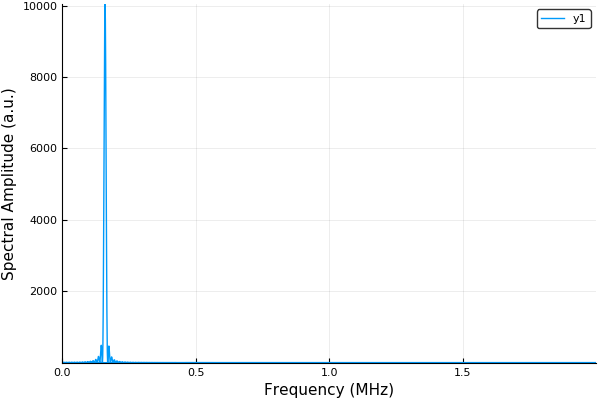

In [27]:
# Take a Fourier transform of the Ramsey signal, and take the positive frequency part of the spectrum 
zero_pad = 10000
N = length(delays)+zero_pad
W = abs2.(fftshift(fft([p1-0.5 ;zeros(zero_pad,1)])))[round(Int,N/2):end]
dt = (delays[2]-delays[1])
fs = 1/dt
f = collect(0:fs/N:fs/2)

# Find frequency corresponding to the maximum in the spectrum
fft_found_freq = f[find(x->x==maximum(W),W)][1]
print(fft_found_freq)

plot(f, W, xlabel="Frequency (MHz)", ylabel="Spectral Amplitude (a.u.)")

In [28]:
# Fit the data above to a sine-model to extract out the qubit frequency. Seed the initial guess with the 
# frequency found from the FFT. 
sinemodel(x,p) = 0.5*cos.(2π*p[1]*x+p[2])+0.5
params0 = [fft_found_freq, 0.0]
fit = curve_fit(sinemodel, delays, p1, params0)
fit_freq = round(fit.param[1],3)
println("fit frequency (MHz): ", round(fit_freq*1e3,5))

fit frequency (MHz): 160.0


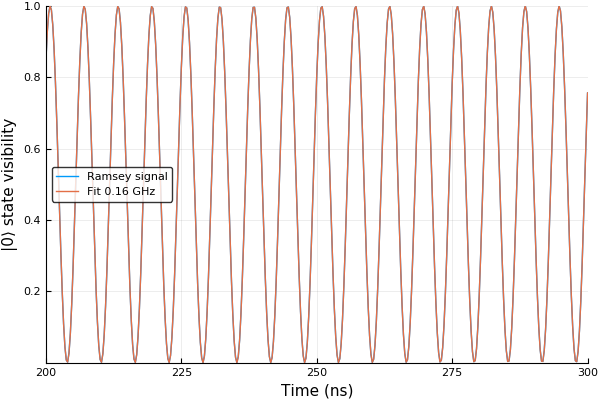

In [29]:
p = plot(delays, [p1 sinemodel(delays, fit.param)], label=["Ramsey signal" "Fit $fit_freq GHz"])
plot!(p, xlabel="Time (ns)", ylabel = "|0⟩ state visibility")

In [20]:
# Now loop over the flux pulse amplitudes i.e. modulation detuning scan.

delays = 200:0.5:250
flux_amps = 0.05:0.1:1.2
fit_freqs_varamp = []
flux_freq = 0.5

# Define fft params
zero_pad = 10000 
N = length(delays)+zero_pad
dt = (delays[2]-delays[1])
fs = 1/dt
f = collect(0:fs/N:fs/2)

@showprogress 1 "Computing..." for flux_amp = flux_amps
    states_gaussian = []    
    for delay = delays
        cqs = CompositeQSystem([q1]);        

        #Apply a flux drive
        add_hamiltonian!(cqs, flux_drive(q1, t -> flux_amp*erfsquare(t, t0+pulse_length, 
                                                                delay-pulse_length,
                                                                risetime=20, 
                                                                pad=10).*cos(2π*flux_freq*t)), q1)
        # Move into the rotating frame
        add_hamiltonian!(cqs, -tun_qubit_freq*number(q1), q1) 

        # Apply the gate drives
        add_hamiltonian!(cqs, microwave_drive(q1, t -> ramsey_gaussian(pulse_length, 0, 
                                                                           t, t0, delay, π_amp)), q1);
        ψs = unitary_state(cqs, [0, delay+t0+pulse_length+30], ψ0)
        push!(states_gaussian, ψs[end])    
     end
    p0 = [abs2(s[1]) for s in states_gaussian];
    W = abs2.(fftshift(fft([p0-0.5 ;zeros(zero_pad,1)])))[round(Int,N/2):end]
    freq_guess = f[find(x->x==maximum(W),W)][1]    
    fit = curve_fit(sinemodel, delays, p0, [freq_guess, 0])
    freq = fit.param[1]
    push!(fit_freqs_varamp, freq)
end

Computing...100%|███████████████████████████████████████| Time: 0:01:11


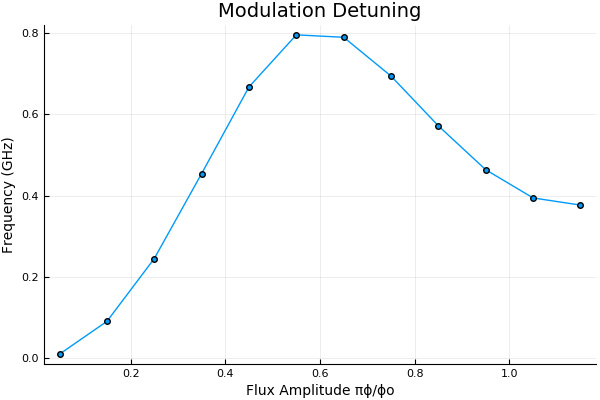

In [21]:
p = plot(flux_amps, fit_freqs_varamp, 
         xlabel="Flux Amplitude πϕ/ϕo", 
         ylabel = "Frequency (GHz)", 
         guidefont=10,
         legend=false, 
         m=:circle,
         title="Modulation Detuning")